# Doom Defend the Center with dqn

The purpose of this scenario is to teach the agent that killing the monsters is GOOD and when monsters kill you is BAD. In addition, wasting amunition is not very good either. Agent is rewarded only for killing monsters so he has to figure out the rest for himself.

### Enviroment:

Map is a large circle. Player is spawned in the exact center. 5 melee-only, monsters are spawned along the wall. Monsters are killed after a single shot. After dying each monster is respawned after some time.Episode ends when the player dies.

### Actions:
 - turn left
 - turn right
 - shoot (attack)

### REWARDS:
 - +1 for killing a monster
 - -1 for death penalty

## Step 1: Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random                # Handling random number generation
import time                  # Handling time calculation
import cv2
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from vizdoom import *        # Doom Environment

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [2]:

"""
Here we create our environment
"""
def create_environment():
    game = DoomGame()
    
    # Load the correct configuration
    game.load_config("doom_files/defend_the_center.cfg")
    
    # Load the correct scenario (in our case defend_the_center scenario)
    game.set_doom_scenario_path("doom_files/defend_the_center.wad")
    
    # Here our possible actions
    # [[1,0,0],[0,1,0],[0,0,1]]
    possible_actions  = np.identity(3,dtype=int).tolist()
    
    return game, possible_actions
game, possible_actions = create_environment()

In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


## Step 3: Viewing our Enviroment

The size of frame is: ( 480 ,  640 )
No. of Actions:  [[1, 0, 0], [0, 1, 0], [0, 0, 1]]


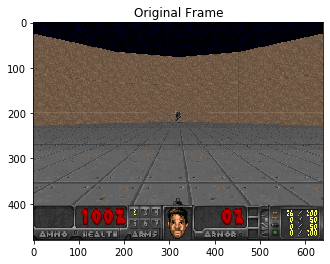

In [4]:
print("The size of frame is: (", game.get_screen_height(), ", ", game.get_screen_width(), ")")
print("No. of Actions: ", possible_actions)
game.init()
plt.figure()
plt.imshow(game.get_state().screen_buffer.transpose(1, 2, 0))
plt.title('Original Frame')
plt.show()
game.close()

#### Execute the code cell below to play Doom with a random policy.

In [5]:
def random_play():
    game.init()
    game.new_episode()
    score = 0
    while True:
        reward = game.make_action(possible_actions[np.random.randint(3)])
        done = game.is_episode_finished()
        score += reward
        time.sleep(0.01)
        if done:
            print("Your total score is: ", score)
            game.close()
            break
random_play()

Your total score is:  -1.0


## Step 4:Preprocessing Frame

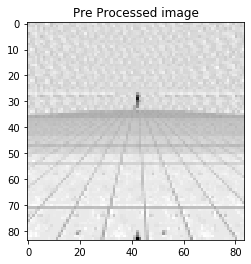

In [6]:
def preprocess_frame(screen):
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[100:-80, 4:-12]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (84, 84), interpolation = cv2.INTER_AREA)
    return screen

game.init()
plt.figure()
plt.imshow(preprocess_frame(game.get_state().screen_buffer.transpose(1, 2, 0)), cmap="gray")
game.close()
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [7]:
def stack_frame(stacked_frames, state, is_new=False):
    frame = preprocess_frame(state)
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

## Step 6: Creating Replay Memory

In [8]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        experiences = random.sample(self.memory, batch_size)
        
        states = torch.from_numpy(np.array([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.array([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences])).float().to(device)
        
        return (states, actions, rewards, next_states)

    def __len__(self):
        return len(self.memory)

## Step 7: Creating Deep Learning Model

In [9]:
class DQN(nn.Module):
    def __init__(self, num_actions=6):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)

## Step 8: Creating out agent

In [10]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 0.0001             # learning rate 
UPDATE_EVERY = 4        # how often to update the network
class Agent():
    def __init__(self, action_size):
        self.action_size = action_size
        
        # Q-Network
        self.policy_net = DQN(action_size).to(device)
        self.target_net = DQN(action_size).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        
        # Replay memory
        self.memory = ReplayMemory(BUFFER_SIZE)
        
        self.t_step = 0
    
    def step(self, state, action, reward, next_state):
        # Save experience in replay memory
        self.memory.push(state, action, reward, next_state)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(BATCH_SIZE)
                self.learn(experiences, GAMMA)
                
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).unsqueeze(0).to(device)
        self.policy_net.eval()
        with torch.no_grad():
            action_values = self.policy_net(state)
        self.policy_net.train()
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next)

        # Get expected Q values from local model
        Q_expected = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.policy_net, self.target_net, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Step 9: Watching untrained agent play

In [11]:
agent = Agent(action_size=3)

# watch an untrained agent
game.init()
score = 0
state = stack_frame(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
while True:
    action = agent.act(state)
    score += game.make_action(possible_actions[action])
    done = game.is_episode_finished()
    if done:
        print("Your total score is: ", score)
        break
    else:
        state = stack_frame(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
        
game.close()

Your total score is:  -1.0


## Step 10: Loading Agent
Uncomment line to load a pretrained agent(TODO)

In [12]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=100)

## Step 11: Train the Agent with DQN

In [13]:
def train(n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    eps = eps_start
    global start_epoch
    game.init()
    for i_episode in range(start_epoch + 1, n_episodes+1):
        game.new_episode()
        state = stack_frame(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
        score = 0
        while True:
            action = agent.act(state, eps)
            reward = game.make_action(possible_actions[action])
            done = game.is_episode_finished()
            score += reward
            if done:
                agent.step(state, action, reward, state)
                break
            else:
                next_state = stack_frame(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
                agent.step(state, action, reward, next_state)
                state = next_state
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    
    game.close()
    return scores

c:\users\deepanshu\.conda\envs\ai\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode 100	Average Score: 0.26


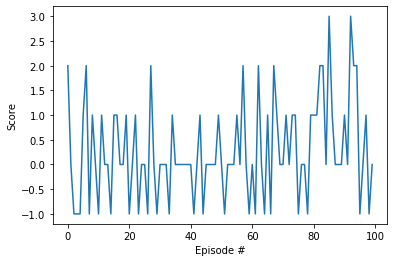

In [14]:
scores = train(100)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Step 12: Watch a Smart Agent!

In [16]:
# watch an trained agent
game.init()
score = 0
state = stack_frame(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
while True:
    action = agent.act(state)
    score += game.make_action(possible_actions[action])
    done = game.is_episode_finished()
    if done:
        print("Your total score is: ", score)
        break
    else:
        state = stack_frame(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
        
game.close()

Your total score is:  -1.0
